# Empirical Fluctuation Processes

Investigation into running EFP tests from `strucchange` in Python using `numba`.

Notes:
- Implementation of recursive residuals in [`statsmodels.sandbox.stats.diagnostic.recursive_olsresiduals`](https://github.com/statsmodels/statsmodels/blob/master/statsmodels/sandbox/stats/diagnostic.py#L1101)

### Setup

In [1]:
import datetime as dt

import numba as nb
import numpy as np
import sklearn.linear_model

In [2]:
import patsy
import yatsm

# Observations
cfg = yatsm.config_parser.parse_config_file('../../examples/p022r049/p022r049.yaml')
df = yatsm.utils.csvfile_to_dataframe(cfg['dataset']['input_file'])

Y = yatsm.reader.read_pixel_timeseries(df['filename'], 75, 75)

# Design matrix
from yatsm.regression.transforms import harm

design = '1 + x + harm(x, 1) + harm(x, 2) + harm(x, 3)'
X = patsy.dmatrix(design, {'x': df['date']})

# Mask
mask = np.in1d(Y[-1, :], [0, 1])

Y = Y[:-1, mask]
X = X[mask, :]

y = Y[4, :]
dates = np.array([dt.datetime.fromordinal(int(_d)) for _d in X[:, 1]])

In [3]:
model = sklearn.linear_model.LinearRegression()
model = model.fit(X, y)

### Model diagnostics

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/ceholden/conda/envs/yatsm/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>


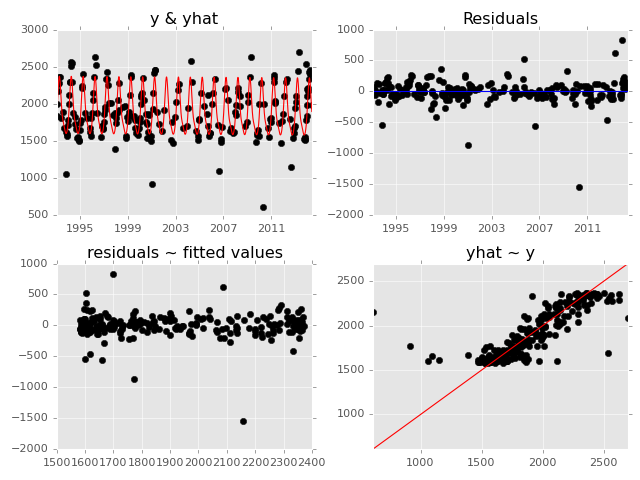

In [5]:
%matplotlib nbagg

yhat = model.predict(X)
resid = y - yhat

# Data & predictions
ax = plt.subplot(221)
_x = np.arange(X[:, 1].min(), X[:, 1].max(), dtype=np.int32)
_date = np.array([dt.datetime.fromordinal(int(_d)) for _d in _x])
_X = patsy.dmatrix(design, {'x': _x})
_yhat = model.predict(_X)

ax.plot(dates, y, 'ko')
ax.plot(_date, _yhat, 'r-')
ax.set_title('y & yhat')

# Residuals
ax = plt.subplot(222)
ax.plot(dates, resid, 'ko')
ax.axhline(resid.mean())
ax.set_title('Residuals')

# fitted ~ residuals
ax = plt.subplot(223)
ax.plot(yhat, resid, 'ko')
ax.set_title('residuals ~ fitted values')

# y ~ yhat
ax = plt.subplot(224)
ax_min, ax_max = min(y.min(), yhat.min()), max(y.max(), yhat.max())
ax.plot(y, yhat, 'ko')
ax.set_xlim((ax_min, ax_max))
ax.set_ylim((ax_min, ax_max))
ax.plot([ax_min, ax_max], [ax_min, ax_max], 'r-')
ax.set_title('yhat ~ y')

plt.tight_layout()

## Recursive Residuals

In [185]:
def recresid(X, y, span=None):
    """ Return standardized recursive residuals for y ~ X

    For a matrix :math:`X_t` of :math:`T` total observations of :math:`n`
    variables, the :math:`t` th recursive residual is the forecast prediction
    error for :math:`y_t` using a regression fit on the first :math:`t - 1`
    observations. Recursive residuals are scaled and standardized so they are
    N(0, 1) distributed.

    Using notation from Brown, Durbin, and Evans (1975) and Judge, et al
    (1985):

    .. math::
        w_r =
            \\frac{y_r - \\boldsymbol{x}_r^{\prime}\\boldsymbol{b}_{r-1}}
                  {\sqrt{(1 + \\boldsymbol{x}_r^{\prime}
                   S_{r-1}\\boldsymbol{x}_r)}}
            =
            \\frac
                {y_r - \\boldsymbol{x}_r^{\prime}\\boldsymbol{b}_r}
                {\sqrt{1 - \\boldsymbol{x}_r^{\prime}S_r\\boldsymbol{x}_r}}

        r = k + 1, \ldots, T,

    where :math:`S_{r}` is the residual sum of squares after
    fitting the model on :math:`r` observations.

    A quick way of calculating :math:`\\boldsymbol{b}_r` and
    :math:`S_r` is using an update formula (Equations 4 and 5 in
    Brown, Durbin, and Evans; Equation 5.5.14 and 5.5.15 in Judge et al):

    .. math::
        \\boldsymbol{b}_r
            =
            b_{r-1} +
            \\frac
                {S_{r-1}\\boldsymbol{x}_j
                    (y_r - \\boldsymbol{x}_r^{\prime}\\boldsymbol{b}_{r-1})}
                {1 + \\boldsymbol{x}_r^{\prime}S_{r-1}x_r}

    .. math::
        S_r =
            S_{j-1} -
            \\frac{S_{j-1}\\boldsymbol{x}_r\\boldsymbol{x}_r^{\prime}S_{j-1}}
                  {1 + \\boldsymbol{x}_r^{\prime}S_{j-1}\\boldsymbol{x}_r}

    See the recursive residuals implementation that this follows,
    `recursive_olsresiduals`, within the `statsmodels.stats.diagnostic` module.

    Args:
        X (np.ndarray): 2D (n_features x n_obs) design matrix
        y (np.ndarray): 1D independent variable
        span (int, optional): minimum number of observations for initial
            regression. If ``span`` is None, use the number of features in
            ``X``

    Returns:
        np.ndarray: array containing recursive residuals standardized by
            prediction error variance

    """
    nobs, nvars = X.shape
    if span is None:
        span = nvars

    recresid = np.nan * np.zeros((nobs))
    recvar = np.nan * np.zeros((nobs))

    X0 = X[:span]
    y0 = y[:span]

    # Initial fit
    XTX_j = np.linalg.inv(np.dot(X0.T, X0))
    XTY = np.dot(X0.T, y0)
    beta = np.dot(XTX_j, XTY)

    yhat_j = np.dot(X[span - 1], beta)
    recresid[span - 1] = y[span - 1] - yhat_j
    recvar[span - 1] = 1 + np.dot(X[span - 1],
                                  np.dot(XTX_j, X[span - 1]))
    for j in range(span, nobs):
        x_j = X[j:j + 1, :]
        y_j = y[j]

        # Prediction with previous beta
        yhat_j = np.dot(x_j, beta)
        resid_j = y_j - yhat_j

        # Update
        XTXx_j = np.dot(XTX_j, x_j.T)
        f_t = 1 + np.dot(x_j, XTXx_j)
        XTX_j = XTX_j - np.dot(XTXx_j, XTXx_j.T) / f_t  # eqn 5.5.15

        beta = beta + (XTXx_j * resid_j / f_t).ravel()  # eqn 5.5.14

        recresid[j] = resid_j
        recvar[j] = f_t

    return recresid / np.sqrt(recvar)

In [166]:
%timeit recresid(X, y)

1000 loops, best of 3: 1.96 ms per loop


In [48]:
import statsmodels.api as sm

lm = sm.OLS(y, X).fit()
sm_recresid = sm.stats.diagnostic.recursive_olsresiduals(lm, skip=16)

In [70]:
np.testing.assert_array_equal(sm_recresid[3], recresid(X, y, span=16))

<IPython.core.display.Javascript object>


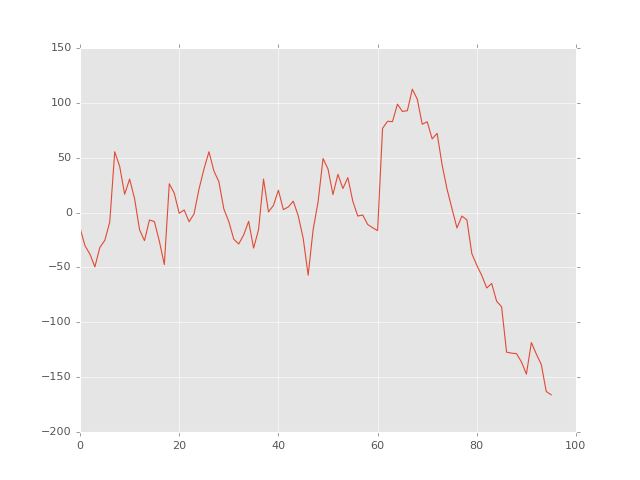

In [167]:
%matplotlib nbagg
plt.plot(recresid(X, y, span=10)[16 - 1:].cumsum()); plt.show()

## EFP

In [193]:
import pandas as pd
import patsy

url = 'http://vincentarelbundock.github.io/Rdatasets/csv/datasets/airquality.csv'
df = pd.read_csv(url)

df.columns = ['Unnamed', 'Ozone', 'SolarR', 'Wind', 'Temp', 'Month', 'Day']
df = df.dropna()

y = np.asarray(df['Ozone'])
X = patsy.dmatrix('1 + SolarR + Wind + Temp', data=df)

rr = recresid(X, y)
rr[X.shape[1]:]

array([ -1.70903938,  -5.70262862,   6.60058663,  -4.8406647 ,
        -9.61248575,   1.22166341,  -9.36237672,   3.82041989,
        21.22022863,  -2.40767377,  13.03096321, -13.9398122 ,
       -16.20292449,  -7.729587  , -11.628317  ,  17.64083394,
         6.55065388,  16.6714667 ,  64.06540054, -13.34543721,
       -25.36237408,  13.78091803, -17.67314184, -28.38356467,
       -10.03231222,  18.85838622,  -1.47379403, -17.98148348,
       -21.21396708,  73.67639092,  -8.56701113, -18.31509788,
         2.94831087, -10.69940079,   7.30225082,  22.59733848,
        18.27504325,  15.60188366, -17.53031352,  -9.74580211,
       -24.87543211, -11.49872358, -16.00518885,  -4.38295812,
         8.23315105,  12.36253625, -24.34510782,  16.83024427,
        46.08329592, -29.98225782,   5.99273212,  13.79960472,
       -17.63393165,   2.36382562,   5.30006071, -13.38159981,
       -20.46299001, -33.64639677,  41.49916939,  25.36351085,
        39.50027142,  -9.52165469, -23.3335897 ,  18.43

<IPython.core.display.Javascript object>


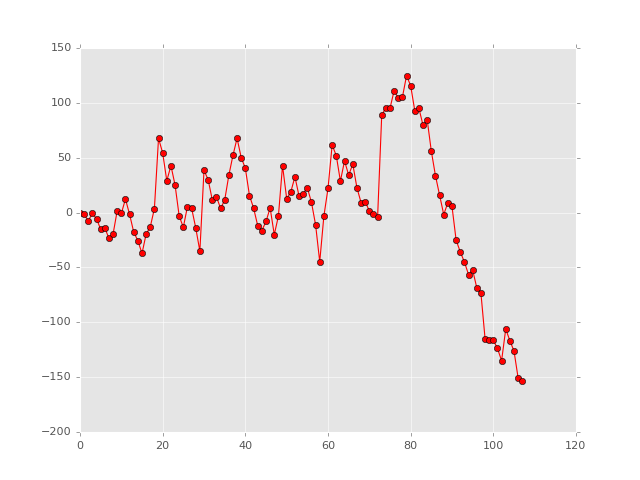

In [195]:
%matplotlib nbagg

rr = recresid(X, y)

plt.plot(rr[~np.isnan(rr)].cumsum(), 'ro-')
plt.show()